
# Subtracting normality

Lately, I was gazing at the beatiful graphs created by Chris Deotte once again:
https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899/notebook

...thinking that they have told us to look for weird ubnormal stuff. To do so we have to substract normality, so here we go.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from tqdm import tnrange, tqdm, tqdm_notebook
import numpy as np, pandas as pd
import os
print("..\input")


from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

# What happens when you're normal

Lets generate two normal distributions and subtract one from the other:

Text(0.5, 0, 'norm1-norm3')

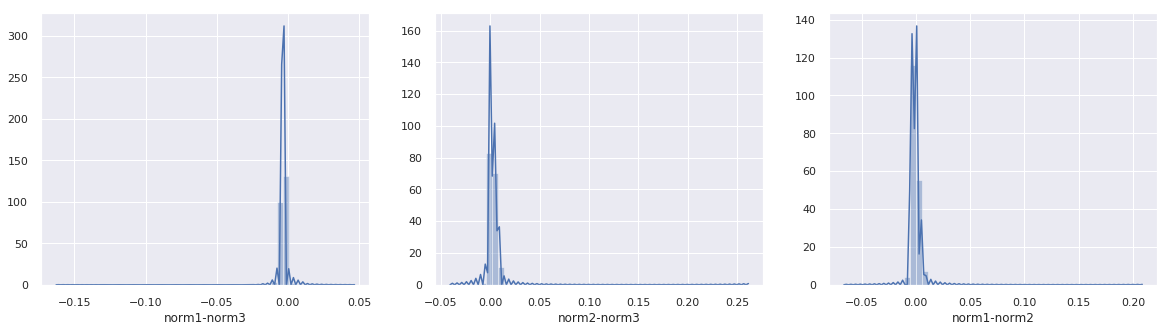

In [5]:
mu = 0.497073351173995
sigma = 0.8105721059584674

# Generate three normal distributions:
norm1 = np.sort(np.random.normal(mu, sigma, 400000))
norm2 = np.sort(np.random.normal(mu, sigma, 400000))
norm3 = np.sort(np.random.normal(mu, sigma, 400000))

# Plor graphs of their paiwise difference:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(norm1-norm2, ax=ax[0])
sns.distplot(norm2-norm3, ax=ax[1])
sns.distplot(norm1-norm3, ax=ax[2])

ax[2].set_xlabel("norm1-norm2")
ax[1].set_xlabel("norm2-norm3")
ax[0].set_xlabel("norm1-norm3")

Two things to note:
1. There is single peak at zero.
2. Substracting one sorted array from another is probably not the best way to "substract normality".

It maybe Ok for exploration, but for the actual data there should be a cleaner way to do this.

# A conspiracy theory
What if I would want to hide that my data is categorical? I could add gaussian noise to category values.

Text(0.5, 0, '2 categories')

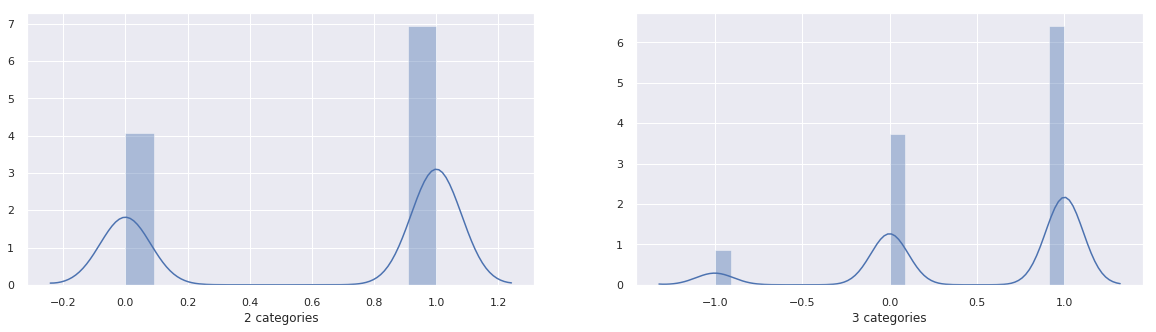

In [6]:
categ_2 = np.hstack((np.zeros(3800),np.ones(6500)))
categ_3 = np.hstack((np.zeros(3500),np.ones(6000), np.ones(800)*-1))

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(categ_2, ax=ax[0])
sns.distplot(categ_3, ax=ax[1])
                    
ax[1].set_xlabel("3 categories")
ax[0].set_xlabel("2 categories")

Text(0.5, 0, '2 categories')

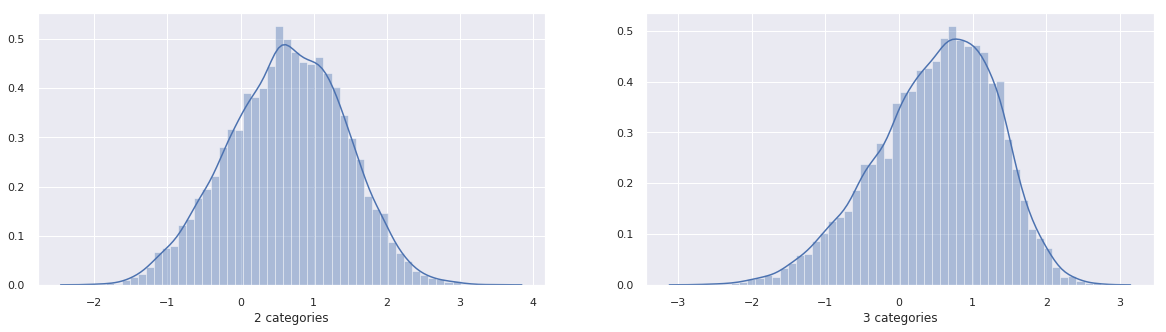

In [7]:
# Lets try to add some noise to categories:
noise_categ_2 = categ_2 + np.random.normal(loc=0.0, scale=categ_2.mean(), size=categ_2.shape)
noise_categ_3 = categ_3 + np.random.normal(loc=0.0, scale=categ_3.mean(), size=categ_3.shape)

# And plot:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(noise_categ_2, ax=ax[0])
sns.distplot(noise_categ_3, ax=ax[1])
                    
ax[1].set_xlabel("3 categories")
ax[0].set_xlabel("2 categories")

The shapes look familiar.

In [ ]:
# Now we will try to substract the normality:
diff_categ_2 = np.sort(noise_categ_2) - np.sort(np.random.normal(noise_categ_2.mean(), noise_categ_2.std(), 10300))
diff_categ_3 = np.sort(noise_categ_3) - np.sort(np.random.normal(noise_categ_3.mean(), noise_categ_3.std(), 10300))

# And plot:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(diff_categ_2, ax=ax[0])
sns.distplot(diff_categ_3, ax=ax[1])
                    
ax[1].set_xlabel("Denoised 3 categories")
ax[0].set_xlabel("Denoised 2 categories")

As you see substracting sorted array is not the best way to restore original categories. But categorical data with added noise looks different after the trick. Lets try doing it to our data.

# Load our data

In [ ]:
train_file = '../input/train.csv'
test_file = '../input/test.csv'

train = pd.read_csv(train_file, index_col='ID_code')
X_test = pd.read_csv(test_file, index_col='ID_code')

In [ ]:
y_train = train.iloc[:,0]
X_train = train.iloc[:,1:]

In [ ]:
X_all = pd.concat([X_test, X_train])

# Substracting normality?

In [ ]:
for col in tqdm_notebook(X_all.columns):
    mu = X_all[col].mean()
    sigma = X_all[col].std()
    minus = np.sort(np.random.normal(mu, sigma, 400000))
    ser = X_all[col].sort_values(ascending=True) - minus
    X_all[col] = ser[X_all.index]

In [ ]:
test = X_all.loc[X_test.index,:].reset_index(drop=True)
train = X_all.loc[X_train.index,:].reset_index(drop=True)

train0 = train[y_train.values==0].copy()
train1 = train[y_train.values==1].copy()

# Statistical Functions
Below are functions to calcuate various statistical things.

In [ ]:
# CALCULATE MEANS AND STANDARD DEVIATIONS
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(train['var_'+str(i)])
    m[i] = np.mean(train['var_'+str(i)])
    
# CALCULATE PROB(TARGET=1 | X)
def getp(i,x):
    c = 3 #smoothing factor
    a = len( train1[ (train1['var_'+str(i)] > x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)] > x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    if a+b<500: return 0.1 #smoothing factor
    # RETURN PROBABILITY
    return a / (a+b)
    # ALTERNATIVELY RETURN ODDS
    # return a / b
    
# SMOOTH A DISCRETE FUNCTION
def smooth(x,st=1):
    for j in range(st):
        x2 = np.ones(len(x)) * 0.1
        for i in range(len(x)-2):
            x2[i+1] = 0.25*x[i]+0.5*x[i+1]+0.25*x[i+2]
        x = x2.copy()
    return x

# Categories?: Display Target Density and Target Probability
As described by Chris: "Below are two plots for each of the 200 variables. The first is the density of `target=1` versus `target=0`. The second gives the probability that `target=1` given different values for `var_k`." 

Note how the shape and the range of graphs are consistnent. All we need to do is to sort them in the right order. Does not it remind you of the last Santander? I am pretty sure the correct order can be restored.

In [ ]:
# DRAW PLOTS, YES OR NO
Picture = True
# DATA HAS Z-SCORE RANGE OF -4.5 TO 4.5
rmin=-5; rmax=5; 
# CALCULATE PROBABILITIES FOR 501 BINS
res=501
# STORE PROBABILITIES IN PR
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in tnrange(50, desc='1st loop'):
    if Picture: plt.figure(figsize=(15,8))
    for v in tnrange(4, desc='1st loop'):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):
            pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
            xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
            xr2[v+4*j,ct] = i
            ct += 1
        if Picture:
            # SMOOTH FUNCTION FOR PRETTIER DISPLAY
            # BUT USE UNSMOOTHED FUNCTION FOR PREDICTION
            pr2[v+4*j,:] = smooth(pr[v+4*j,:],res//10)
            # DISPLAY PROBABILITY FUNCTION
            plt.subplot(2, 4, ct2%4+5)
            plt.plot(xr[v+4*j,:],pr2[v+4*j,:],'-')
            plt.title('P( t=1 | var_'+str(v+4*j)+' )')
            xx = plt.xlim()
            # DISPLAY TARGET DENSITIES
            plt.subplot(2, 4, ct2%4+1)
            sns.distplot(test['var_'+str(v+4*j)], label = 'test')
            sns.distplot(train0['var_'+str(v+4*j)], label = 't=0')
            sns.distplot(train1['var_'+str(v+4*j)], label = 't=1')
            plt.title('var_'+str(v+4*j))
            plt.legend()
            plt.xlim(xx)
            plt.xlabel('')
        if (ct2%8==0): print('Showing vars',ct2,'to',ct2+7,'...')
        ct2 += 1
    if Picture: plt.show()

# Afterthoughts
I have not tried to go beyond this, so I am not even sure that this works. But I will certainly try. All comments are welcome. So if you have reasons to think this is bollocks, please say so.